# **Inference pipeline**
___  
  
In this notebook we show how to apply **inference** with [BiaPy](https://biapyx.github.io/).  

**Without any coding**, we explain step by step how to
1. **upload a set of test images** with their corresponding labels,
2. **apply the model** to the test images, and
4. **download the results** to your local machine.

**Disclaimer:** the structure of the notebook is heavily inspired in the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook was created by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus), [Lenka Backová](mailto:lenka.backova@ehu.eus), [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org) and [Ane Paniagua](mailto:anepaniagua@gmail.com). For suggestions, comments, or issues, please reach out to us via email or [create an issue in BiaPy's repository](https://github.com/BiaPyX/BiaPy/issues). Thank you!


## **Expected inputs and outputs**
___
**Inputs**

This notebook expects three folders as input:
* **Test raw images**: with the raw images to test the model.
* **Test labels**: ground truth of the test images. Depending on the workflow to be used, the inputs will be images or CSV files.
* **Output folder**: a path to store the results.

**Outputs**

Depending on the workflow, the output could be an image, or a csv file per each test sample.

<font color='red'><b>Note</b></font>: for testing purposes, you can also run this notebook with the **example datasets provided in 'Manage file(s) source > Option 3'**.

**Data structure**

To ensure the proper operation of the library the data directory tree should be something like this:

```
dataset/
└── test
    ├── raw
    │   ├── testing-0001.tif
    │   ├── testing-0002.tif
    │   ├── . . .
    │   └── testing-9999.tif
    └── gt
        ├── testing_groundtruth-0001.tif
        ├── testing_groundtruth-0002.tif
        ├── . . .
        └── testing_groundtruth-9999.tif
```

**⚠️ Warning:** Ensure that images and their corresponding ground truth files are sorted in the same way. A common approach is to fill with zeros the image number added to the filenames (as in the example).

**Input Format Support**

This notebook is compatible with a range of input formats. You can use the following file extensions: `.tif`, `.png`, `.jpg`, `.npy`, `.h5`, `.hdf5` (every extension supported by [scikit-image](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread)).





## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.



## **Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelerator: GPU** *(Graphics processing unit)*

## **Install BiaPy**
---

In [ ]:
#@markdown ##Play to install BiaPy and its dependences
# Install latest release of BiaPy
!pip install biapy==3.6.1

# Then install Pytorch + CUDA 11.8
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu118

# Finally install some packages that rely on the Pytorch installation
!pip install timm==1.0.14 pytorch-msssim torchmetrics[image]==1.4.*


import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
import ipywidgets as widgets
from ipywidgets import Output
from biapy import BiaPy

changed_source = False

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 20.7 MB/s eta 0:00:00
  Attempting uninstall: numcodecs
    Found existing installation: numcodecs 0.15.1
    Uninstalling numcodecs-0.15.1:
      Successfully uninstalled numcodecs-0.15.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 411.1/411.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.0/203.0 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 63.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.0/948.0 kB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
#@markdown ##Play to download an example dataset
!pip install gdown==5.1.0 --quiet
import gdown
import os

os.chdir('/content/')
gdown.download("https://drive.google.com/uc?id=10Cf11PtERq4pDHCJroekxu_hf10EZzwG", "fibsem_epfl.zip", quiet=True)

!unzip -q fibsem_epfl.zip
!rm fibsem_epfl.zip

print( 'Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data


## **Manage file(s) source**
---
The input folder can be provided using three different options: by directly uploading the folder (option 1), by using a folder stored in Google Drive (option 2) or by using a few samples of our data (option 3).

Depending on the option chosen, different steps will have to be taken, as explained in the following cells.


### **Option 1: Upload Files from Your Local Machine**
---
You will be prompted to upload your files to Colab and they will be stored under `/content/input/`.

In [ ]:
#@markdown ##Play the cell to upload local files (test raw images)

from google.colab import files
import os
input_dir = '/content/input/test/raw'

if os.path.exists(input_dir):
    # Ask the user if they want to delete the existing items in the folder
    delete_items = ''
    while not delete_items in ['y', 'n']:
        delete_items = input("Do you want to delete the existing items in the folder? (yes[y]/no[n]): ").strip().lower()
    if delete_items == 'y':
        for delete_root, delete_dirs, delete_files in os.walk(input_dir, topdown=False):
            for name in delete_files:
                os.unlink(os.path.join(delete_root, name))
else:
    # Ensure the directory exists
    os.makedirs(input_dir, exist_ok=True)


%cd {input_dir}
uploaded = files.upload()
%cd /content

In [ ]:
#@markdown ##Play the cell to upload local files (test ground truth)

from google.colab import files
import os
input_dir = '/content/input/test/gt'

if os.path.exists(input_dir):
    # Ask the user if they want to delete the existing items in the folder
    delete_items = ''
    while not delete_items in ['y', 'n']:
        delete_items = input("Do you want to delete the existing items in the folder? (yes[y]/no[n]): ").strip().lower()
    if delete_items == 'y':
        for delete_root, delete_dirs, delete_files in os.walk(input_dir, topdown=False):
            for name in delete_files:
                os.unlink(os.path.join(delete_root, name))
else:
    # Ensure the directory exists
    os.makedirs(input_dir, exist_ok=True)


%cd {input_dir}
uploaded = files.upload()
%cd /content

In [ ]:
# @title  { display-mode: "form" }
#@markdown ##Play the cell to upload local files (YAML file)

from google.colab import files
%cd /content
uploaded = files.upload()

In [ ]:
# @title  { display-mode: "form" }
#@markdown ##Play the cell to upload local files (model's weights)

from google.colab import files
%cd /content
uploaded = files.upload()


### **Option 2: Mount Your Google Drive**
---
To use this notebook on your own data from Google Drive, you need to mount Google Drive first.

Play the cell below to mount your Google Drive and follow the link that will be shown. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive.

Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL.

#@markdown * Sign in your Google Account.

#@markdown * Copy the authorization code.

#@markdown * Enter the authorization code.

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive".

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

## **Paths for Input Images and Output Files**
___

Depending on the option you chose for managing file sources, you'll set your paths differently:

- **Option 1 (Upload from Local Machine)**:
  - Set `test_data_path` to `/content/input/test/raw`
  - Set `test_data_gt_path` to `/content/input/test/gt`
  - Set `yaml_file` to `/content/your_yaml_file.yaml`
  - Set `checkpoint_file` to `/content/your_checkpoint.pth`
  - Set `output_path` to `/content/out`
  
- **Option 2 (Use Google Drive Data)**:
  - Insert the paths to your input files and your desired output directory here, i.e., `/content/gdrive/MyDrive/...`.
  
**Note**: Ensure you download your results from the `/content/out` directory after the process!

**Helpful Tip**: If you're unsure about the paths to your folders, look at the top left of this notebook for a small folder icon. Navigate through the directories until you locate your desired folder. Right-click on it and select "Copy Path" to copy the folder's path.

In [ ]:
#@markdown #####Path to test images
test_data_path = '/content/data/train/raw' #@param {type:"string"}
#@markdown #####Path to test ground truth (if exists)
test_data_gt_path = '/content/data/train/label' #@param {type:"string"}
#@markdown #####Path to the YAML configuration file
yaml_file = '/content/2d_semantic_segmentation.yaml' #@param {type:"string"}
#@markdown #####Path to checkpoint file
checkpoint_file = '/content/2d_semantic_segmentation_1-checkpoint-best.pth' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

import os
from pathlib import Path

def count_image_files(directory):
    if not directory or not os.path.exists(directory):
        return 0
    image_extensions = {'.jpg', '.jpeg', '.png', '.tif', '.npy', '.tiff', '.h5', '.hd5', '.zarr'}
    count = 0
    for root, dirs, files in os.walk(directory):
        for file in files:
            if Path(file).suffix.lower() in image_extensions:
                count += 1
    return count

num_test_images = count_image_files(test_data_path)
print(f"Number of test images: {num_test_images}")

if test_data_gt_path != "":
    num_test_gt = count_image_files(test_data_gt_path)
    print(f"Number of test ground truth files: {num_test_gt}")

Number of test images: 1
Number of test ground truth files: 1


## **Optional: Converting 3D data into 2D**
---
Optionally, you can use this cell to convert your 3D images or videos into 2D images by extracting individual slices or frames. This enables compatibility with a trained 2D model. If this cell is run the paths to these new data will be used automatically.

In [ ]:
#@markdown #####Path to store the 2D images generated from existing 3D
output_2D_slice_folder = '/content/3D_image_slices' #@param {type:"string"}
#@markdown #####Path to store the 2D ground truth images generated from existing 3D (if exists)
output_gt_2D_slice_folder = '/content/3D_gt_image_slices' #@param {type:"string"}

[15:26:05.167506] Converting 1 3D images/videos from folder: /content/data/train/raw


  0%|          | 0/1 [00:00<?, ?it/s]


 98%|█████████▊| 162/165 [00:04<00:00, 33.56it/s]
                                                 

[15:26:09.886361]  
[15:26:09.887152] Number of 2D image slices generated: 165
[15:26:09.887263] Below three random 2D images are depicted


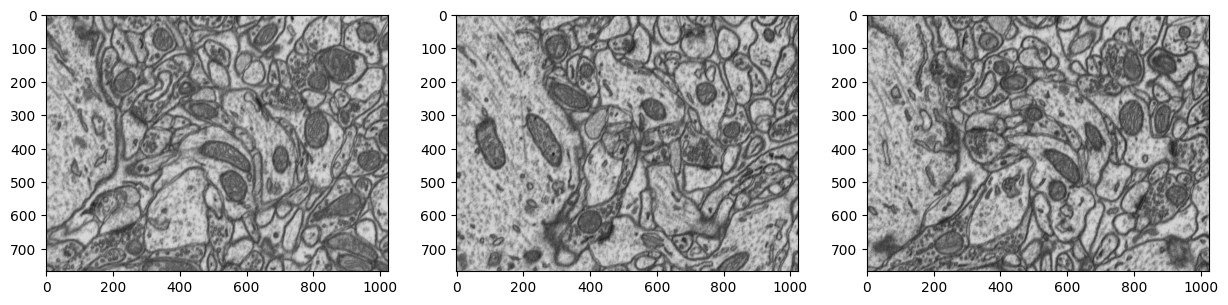

[15:26:10.824933] Converting GT 1 3D images/videos from folder: /content/data/train/label


  0%|          | 0/1 [00:00<?, ?it/s]


 98%|█████████▊| 161/165 [00:01<00:00, 173.10it/s]
                                                  

[15:26:12.109812]  
[15:26:12.110081] Number of 2D image slices generated: 165
[15:26:12.110111] Below three random 2D images are depicted


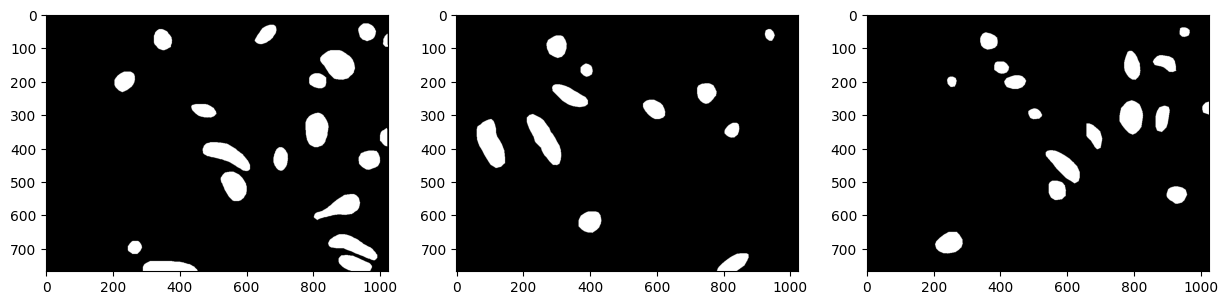

In [ ]:
#@markdown ##Play to generate 2D images from 3D
import h5py
from biapy.data.data_manipulation import save_tif, load_img_data
from tqdm.notebook import tqdm as tqdm

# Checks
if not os.path.exists(test_data_path):
    raise ValueError("Defined path not found: {}. Please define 'test_data_path' path correctly above".format(data_path))

ids = sorted(next(os.walk(test_data_path))[2])
if len(ids) == 0:
    raise ValueError(f"No images found in {test_data_path}")

print(f"Converting {len(ids)} 3D images/videos from folder: {test_data_path}")

original_shapes = []
original_filenames = []

for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    img, img_file = load_img_data(os.path.join(test_data_path, id_), is_3d=True)
    if isinstance(img_file, h5py.File):
        img_file.close()
    original_shapes.append(img.shape)
    original_filenames.append(id_)

    filenames = []
    d = len(str(img.shape[0]))
    for k in range(img.shape[0]):
        filenames.append(os.path.splitext(id_)[0]+"_crop"+str(k).zfill(d)+'.tif')
    save_tif(img, output_2D_slice_folder, filenames, verbose=False)

tmp_folder_ids = sorted(next(os.walk(output_2D_slice_folder))[2])
print(" ")
print(f"Number of 2D image slices generated: {len(tmp_folder_ids)}")

# Show a few examples to heck that they have been stored correctly
print(f"Below three random 2D images are depicted")
%matplotlib inline
from numpy.random import randint, seed
from matplotlib import pyplot as plt

seed(1)
values = randint(0, len(tmp_folder_ids), 3)

test1_sample = imread(os.path.join(output_2D_slice_folder, tmp_folder_ids[values[0]]))
test2_sample = imread(os.path.join(output_2D_slice_folder, tmp_folder_ids[values[1]]))
test3_sample = imread(os.path.join(output_2D_slice_folder, tmp_folder_ids[values[2]]))

plt.figure(figsize=(15,15))
plt.subplot(1, 3, 1)
plt.imshow(test1_sample, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(test2_sample, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(test3_sample, cmap='gray')
plt.show()


# Checks
if os.path.exists(test_data_gt_path):
    gt_ids = sorted(next(os.walk(test_data_gt_path))[2])
    if len(gt_ids) == 0:
        raise ValueError(f"No images found in {test_data_gt_path}")

    print(f"Converting GT {len(gt_ids)} 3D images/videos from folder: {test_data_gt_path}")

    gt_original_shapes = []
    gt_original_filenames = []

    for n, id_ in tqdm(enumerate(gt_ids), total=len(gt_ids)):
        img, img_file = load_img_data(os.path.join(test_data_gt_path, id_), is_3d=True)
        if isinstance(img_file, h5py.File):
            img_file.close()
        original_shapes.append(img.shape)
        original_filenames.append(id_)

        filenames = []
        d = len(str(img.shape[0]))
        for k in range(img.shape[0]):
            filenames.append(os.path.splitext(id_)[0]+"_crop"+str(k).zfill(d)+'.tif')
        save_tif(img, output_gt_2D_slice_folder, filenames, verbose=False)

    tmp_folder_ids = sorted(next(os.walk(output_gt_2D_slice_folder))[2])
    print(" ")
    print(f"Number of 2D image slices generated: {len(tmp_folder_ids)}")

    # Show a few examples to heck that they have been stored correctly
    print(f"Below three random 2D images are depicted")

    seed(1)
    values = randint(0, len(tmp_folder_ids), 3)

    test1_sample = imread(os.path.join(output_gt_2D_slice_folder, tmp_folder_ids[values[0]]))
    test2_sample = imread(os.path.join(output_gt_2D_slice_folder, tmp_folder_ids[values[1]]))
    test3_sample = imread(os.path.join(output_gt_2D_slice_folder, tmp_folder_ids[values[2]]))

    plt.figure(figsize=(15,15))
    plt.subplot(1, 3, 1)
    plt.imshow(test1_sample, cmap='gray')
    plt.subplot(1, 3, 2)
    plt.imshow(test2_sample, cmap='gray')
    plt.subplot(1, 3, 3)
    plt.imshow(test3_sample, cmap='gray')
    plt.show()


## **Configure and apply your DNN model**
---

### **Select your parameters**
---
* **`load_gt`:** Select to load ground truth labels and measure output performance. **Default value: True**

In [ ]:
load_gt = True #@param {type:"boolean"}

### **Make the inference**
---

In [ ]:
#@markdown ##Play to run the model
import os
import errno

os.chdir('/content/')

# Edit previous configuration file if it exists to load the checkpoint model
if os.path.exists( yaml_file ):
    import yaml
    with open( yaml_file, 'r') as stream:
        try:
            biapy_config = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    biapy_config['PATHS'] = {}
    biapy_config['PATHS']['CHECKPOINT_FILE'] = checkpoint_file
    biapy_config['MODEL'] = {}
    biapy_config['MODEL']['LOAD_CHECKPOINT'] = True

    # save file
    with open( yaml_file, 'w') as outfile:
        yaml.dump(biapy_config, outfile, default_flow_style=False)

# Check folders before modifying the .yaml file
if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[2])
if len(ids) == 0:
    raise ValueError("No images found in dir {}".format(test_data_path))

if not os.path.exists(yaml_file):
    raise ValueError("No YAML configuration file found in {}".format(yaml_file))

if not os.path.exists(checkpoint_file):
    raise ValueError("No h5 checkpoint file found in {}".format(checkpoint_file))


# open template configuration file
import yaml
with open( yaml_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

if "output_2D_slice_folder" in locals() or "output_2D_slice_folder" in globals():
    biapy_config['DATA']['TEST']['PATH'] = output_2D_slice_folder
    biapy_config['DATA']['TEST']['GT_PATH'] = output_gt_2D_slice_folder
else:
    biapy_config['DATA']['TEST']['PATH'] = test_data_path
    biapy_config['DATA']['TEST']['GT_PATH'] = test_data_gt_path

biapy_config['DATA']['TEST']['LOAD_GT'] = load_gt
biapy_config['TRAIN']['ENABLE'] = False
biapy_config['TEST']['ENABLE'] = True
biapy_config['MODEL']['LOAD_CHECKPOINT']= True
biapy_config['PATHS'] = {}
biapy_config['PATHS']['CHECKPOINT_FILE']= checkpoint_file

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Inference configuration finished.")

job_name = os.path.splitext(yaml_file)[0].split('/')[-1]

# Run the code
biapy = BiaPy(yaml_file, result_dir=output_path, name=job_name, run_id=1, gpu=0)
biapy.run_job()


## **Optional: Converting 2D slices into 3D again**
---
If you used the optional cell above to generate 2D images from 3D data, you can use this cell to reassemble the predicted 2D slices back into the original 3D image.

In [ ]:
#@markdown #####Path to store the reconstructed 3D images:
reconstructed_stack_folder = '/content/reconstructed_3D_stacks' #@param {type:"string"}

In [ ]:
#@markdown ##Play to generate 2D images from 3D

from biapy.data.data_manipulation import save_tif, load_img_data

ids = sorted(next(os.walk(output_2D_slice_folder))[2])
if len(ids) == 0:
    raise ValueError(f"Something happend as there are no images in the folder pointed by 'output_2D_slice_folder', which is: {output_2D_slice_folder} . Are you sure the predictions have been generated sucessfully in the cell above?")

complete_3d_image = []
num_complete_image = 0
c = 0

# Adjusting the path depending on the configuration
if "FULL_IMG" in biapy_config['TEST'] and biapy_config['TEST']["FULL_IMG"]:
    if os.path.exists(os.path.join(output_path, str(job_name)+'/results/'+str(job_name)+f'_1/full_image_post_processing')):
        print("Seems that you have selected some post-processing as the folder for it has been created. Converting images from there then!")
        last_folder = "full_image_post_processing"
    else:
        last_folder = "full_image"
else:
    if os.path.exists(os.path.join(output_path, str(job_name)+'/results/'+str(job_name)+f'_1/per_image_post_processing')):
        print("Seems that you have selected some post-processing as the folder for it has been created. Converting images from there then!")
        last_folder = "per_image_post_processing"
    else:
        last_folder = "per_image"
if "_post_processing" not in last_folder:
    if biapy_config['PROBLEM']["TYPE"] == "SEMANTIC_SEG":
        last_folder += "_binarized"
    elif biapy_config['PROBLEM']["TYPE"] == "INSTANCE_SEG":
        last_folder += "_instances"

image_folder_to_process = os.path.join(output_path, str(job_name)+'/results/'+str(job_name)+f'_1/{last_folder}')
print(f"Reconstructing original 3D images based on predicted slices from folder: {image_folder_to_process} ")
if not os.path.exists(image_folder_to_process):
    raise ValueError("It looks like the folder wasn't found—you may have missed running a previous cell. If it is not the case please report this unexpected issue.")

ids = sorted(next(os.walk(image_folder_to_process))[2])
for n, id_ in tqdm(enumerate(ids), total=len(ids)):
    img, img_file = load_img_data(os.path.join(image_folder_to_process, id_), is_3d=False)
    if isinstance(img_file, h5py.File):
        img_file.close()
    if original_shapes[num_complete_image][0] != c:
        complete_3d_image.append(np.expand_dims(img, axis=0))
        c += 1
        if original_shapes[num_complete_image][0] == c:
            print("Reconstructing file: {}".format(original_filenames[num_complete_image]))
            complete_3d_image = np.concatenate(complete_3d_image)
            save_tif(np.expand_dims(complete_3d_image,0), reconstructed_stack_folder, [original_filenames[num_complete_image]], verbose=False)
            num_complete_image += 1
            c = 0
            complete_3d_image = []


[15:57:34.378015] Reconstructing original 3D images based on predicted slices from folder: /content/output/2d_semantic_segmentation/results/2d_semantic_segmentation_1/per_image_binarized 


  0%|          | 0/165 [00:00<?, ?it/s]

[15:57:34.853996] Reconstructing file: training.tif



100%|██████████| 1/1 [00:02<00:00,  2.48s/it]
                                             

## **Download results**
---

In [ ]:
#@markdown ###Play to download a zip file with all the results in test.

from google.colab import files

os.chdir('/content/')

!zip -r -q /content/output.zip $output_path

files.download("/content/output.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Acknowledgments**
---
We would like to acknowledge the inspiration provided by the excellent [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).